In [103]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 
import scanpy as sc 
import seaborn as sns
import anndata as ad
from sklearn.decomposition import PCA 
from sklearn.metrics import roc_auc_score, average_precision_score, mean_squared_error, mean_absolute_error
import torch.nn as nn
from scipy.sparse import coo_matrix

def softmax(x, tau = 1):
    x = x / tau
    e_x = np.exp(x - np.max(x, axis=1, keepdims=True))  # 数值稳定性处理
    return e_x / e_x.sum(axis=1, keepdims=True)

from scipy.sparse import csr_matrix 

def sparse_softmax(matrix, tau = 1):

    X = matrix.toarray()
    X[X == 0] = np.inf 
    X = -X/tau
    res = softmax(X, tau = tau)
    return res

import faiss
import numpy as np

def find_topk_neighbors(X, Y, k=5):
    """
    使用 FAISS 加速查找 X 中每个细胞在 Y 中的 top-k 最近邻。 
    X query cell embedding
    Y key cell embedding 
    """
    d = X.shape[1]  # dimension of embeddings

    # 构建 index
    index = faiss.IndexFlatL2(d)  # L2 distance
    index.add(Y.astype(np.float32))
    
    # search
    D, I = index.search(X.astype(np.float32), k)  # I is the indices in Y
    
    return I  # shape: (n_cells_X, k)

def l2_distance(x,y):
    return np.sqrt(np.sum((x-y)**2))

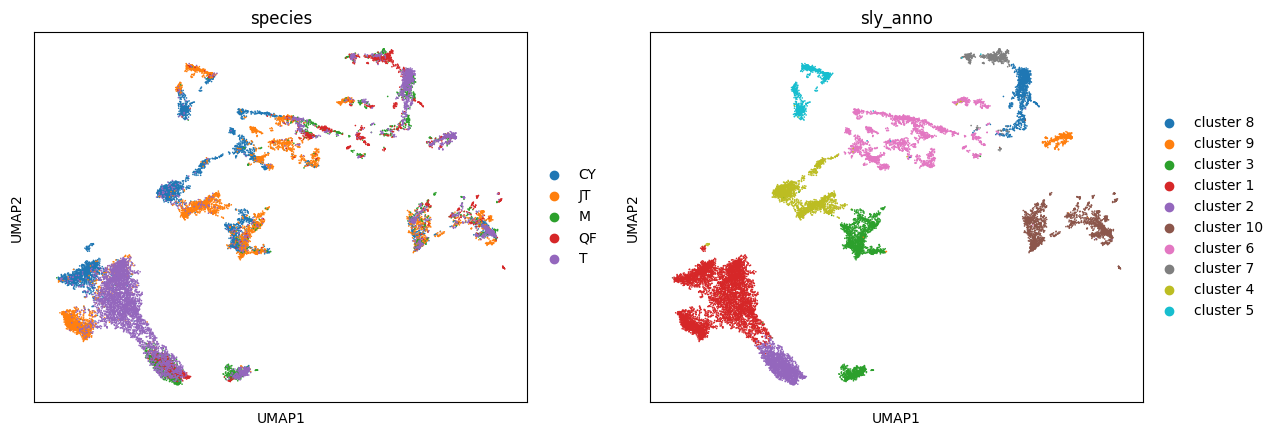

In [5]:
scdata = sc.read_h5ad('multi_raw.h5ad')
sc.pl.umap(scdata, color = ['species','sly_anno'])


## Target

注意到cluster1, cluster2 中都分布有猪尾鼠细胞，我们希望将猪尾鼠的和非回声物种分开

CY (5363, 9911)


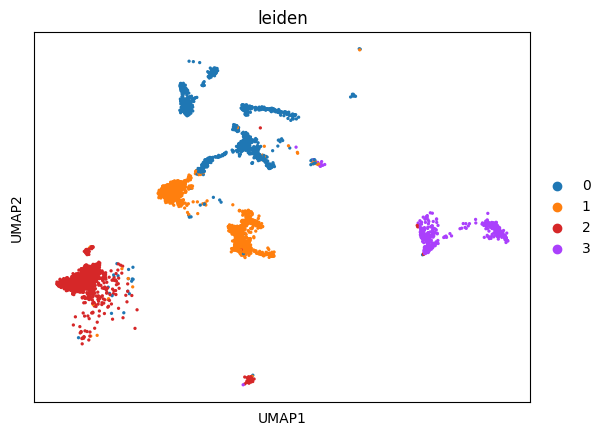

JT (5789, 9911)


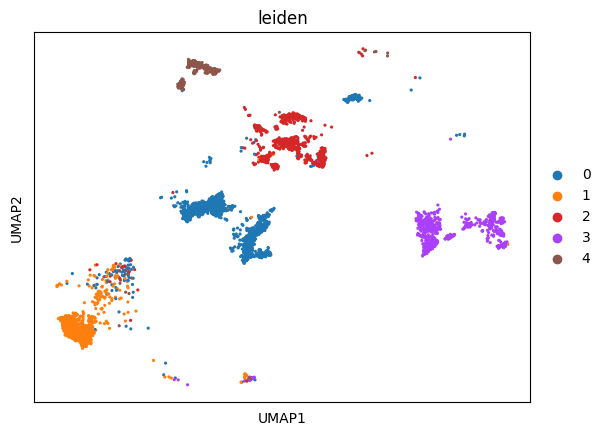

M (2445, 9911)


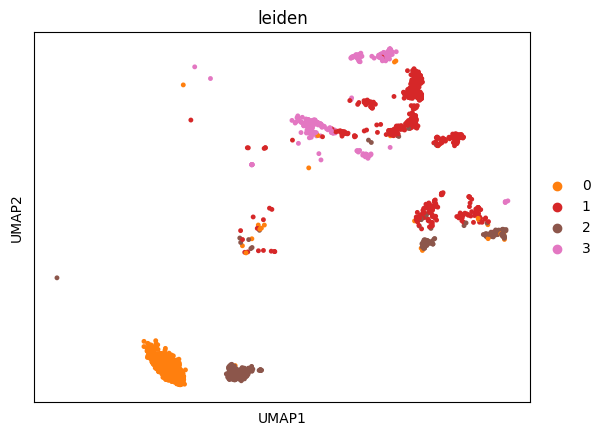

QF (2033, 9911)


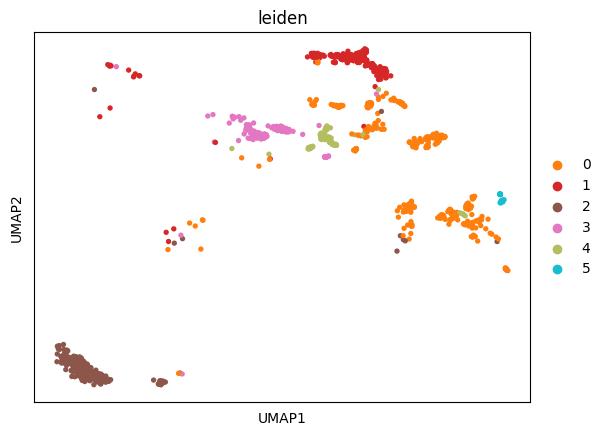

T (6231, 9911)


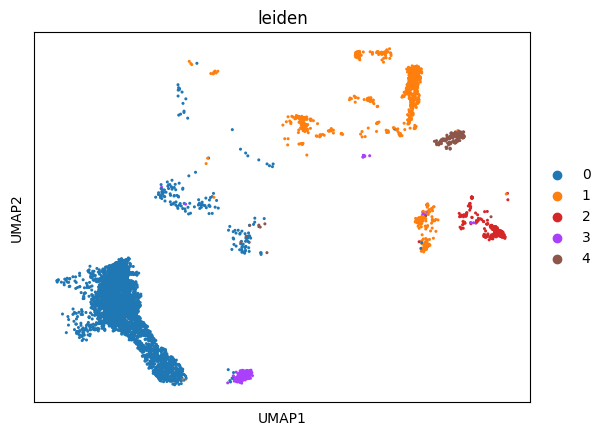

In [12]:
data_dic = {}

for species in scdata.obs.species.unique():

    adata = scdata[scdata.obs.species == species]
    print(f'{species} {adata.shape}')

    sc.pp.neighbors(adata, use_rep = 'X_pca_harmony')
    sc.tl.leiden(adata, resolution = 0.15)
    sc.pl.umap(adata, color = 'leiden')
    data_dic[species] = adata

In [46]:
species_list = scdata.obs.species.unique()
cluster_embed = {}
species_pos = {}

tmp = 0
for species in species_list:
    adata = data_dic[species]
    cluster_ids = np.sort(adata.obs.leiden.unique().astype('object'))

    for idx in cluster_ids:
        sel_id = adata.obs.leiden == idx 
        pca_embed = adata.obsm['X_pca_harmony'][sel_id,:]
        cluster_embed[f'{species}_{idx}'] = pca_embed.mean(axis=0)
    
    species_pos[species] = (tmp, tmp + len(cluster_ids))
    tmp += len(cluster_ids)

cluster_df = pd.DataFrame(cluster_embed).T
from scipy.spatial.distance import pdist, squareform

cluster_cluster_weight = squareform(pdist(cluster_df.values, metric='correlation')) # metric = 'cosine
cluster_cluster_weight = pd.DataFrame(cluster_cluster_weight, index=cluster_df.index, columns=cluster_df.index)

weight_copy =  cluster_cluster_weight.copy()

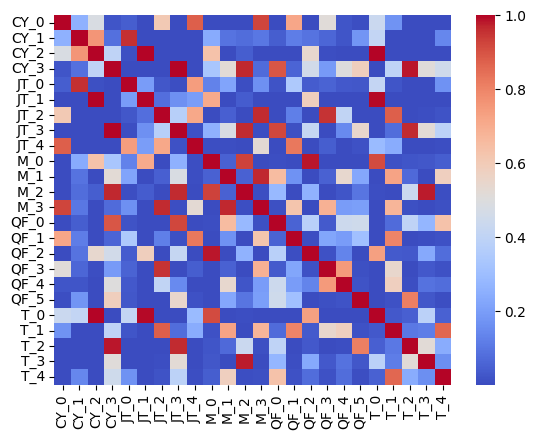

In [97]:
## normalize cross species cluster weight 

idx = np.arange(len(weight_copy))

for species in species_list:
    for com_species in species_list:

        if species == com_species:
            a,b = species_pos[species]

            sel_index = idx[a:b]
            cross_df = weight_copy.iloc[sel_index, sel_index]
            for i in range(cross_df.shape[0]):
                cross_df.iloc[i,i] = np.inf            
            cluster_cluster_weight.iloc[sel_index, sel_index] = softmax(-cross_df.values, tau = 0.1)
            
        else:
            a,b = species_pos[species]
            c,d = species_pos[com_species]

            sel_index = idx[a:b]
            sel_columns = idx[c:d]
            cross_df = weight_copy.iloc[sel_index, sel_columns]
            cluster_cluster_weight.iloc[sel_index, sel_columns] = softmax(-cross_df.values, tau = 0.1)

for i in range(cluster_cluster_weight.shape[0]):
    cluster_cluster_weight.iloc[i,i] = 1

cluster_cluster_weight = (cluster_cluster_weight + cluster_cluster_weight.T)/2

sns.heatmap(cluster_cluster_weight, cmap = 'coolwarm')
plt.show()

<AxesSubplot: >

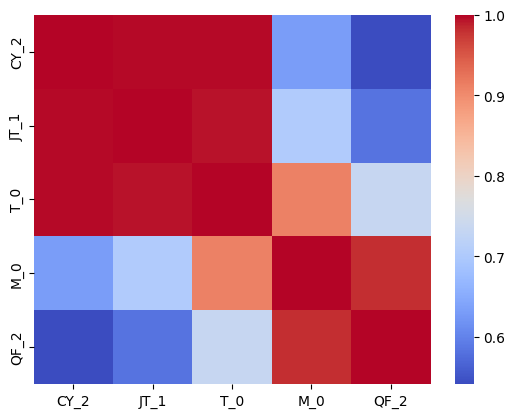

In [98]:
tmp = ['CY_2','JT_1','T_0','M_0','QF_2']
sns.heatmap(cluster_cluster_weight.loc[tmp,tmp],cmap='coolwarm')

### modify不合理的边 

原始的knn 图 id --> adata 中 的id 

In [129]:
s_node2id = {}

for species in['CY','JT','T','M','QF']:
    adata = data_dic[species]
    tmp = {}
    for i,idx in enumerate(adata.obs.index.values):
        tmp[idx] = i 
    s_node2id[species] = tmp


node2id = {}

for i,idx in enumerate(scdata.obs.index.values):
    species = idx.split('-')[0][:-2]
    node2id[idx] = s_node2id[species][idx]

id2node = {}
for key in node2id.keys():
    id2node[node2id[key]] = key

In [137]:
from tqdm import tqdm
adaj = scdata.obsp['connectivities'].tocoo()
rows = adaj.row
cols = adaj.col

modify_list = []

delta = 0.95
for i in tqdm(range(len(rows))):
    row = rows[i]
    col = cols[i]

    row_idx = scdata.obs.index[row]
    col_idx = scdata.obs.index[col]

    species_r = scdata.obs.iloc[row,:]['species']
    species_c = scdata.obs.iloc[col,:]['species']

    cluster_row = data_dic[species_r].obs.loc[row_idx,'leiden']
    cluster_col = data_dic[species_c].obs.loc[col_idx,'leiden']

    a = species_r + '_' + cluster_row
    b = species_c + '_' + cluster_col 

    if cluster_cluster_weight.loc[a,b] >= 0.95:
        continue
    else:
        modify_list.append([row, col])


100%|██████████| 472430/472430 [02:44<00:00, 2872.73it/s]


In [140]:
print(f'frac of not conserved links {len(modify_list) / 472430}')

frac of not conserved links 0.1840568973181212


### 不成功的尝试

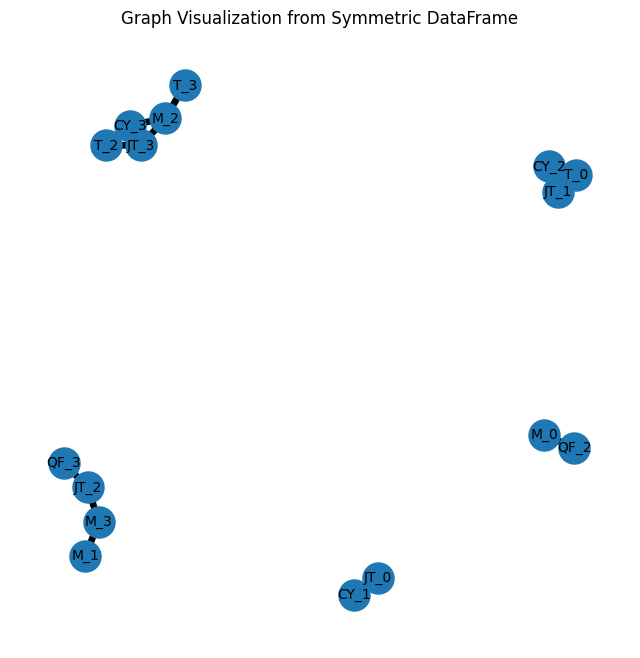

In [99]:

import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

# 假设你已经有了一个对称的 n*n DataFrame 叫做 df
# 这里我们随机生成一个对称的 5x5 DataFrame 作为示例
n = 5
df = pd.DataFrame(np.random.rand(n, n), index=[f'Node{i}' for i in range(n)], columns=[f'Node{i}' for i in range(n)])
df = cluster_cluster_weight

# 创建一个无向图
G = nx.Graph()

# 添加节点和边
for i in range(df.shape[0]):
    for j in range(i + 1, df.shape[1]):
        if df.iloc[i, j] > 0.95:  # 设置一个阈值来决定是否添加边
            G.add_edge(df.index[i], df.columns[j], weight=df.iloc[i, j])

# 可视化图
plt.figure(figsize=(8,8))
pos = nx.spring_layout(G)  # 使用 spring 布局
edges = G.edges(data=True)

# 绘制节点
nx.draw_networkx_nodes(G, pos, node_size=500)

# 绘制边
nx.draw_networkx_edges(G, pos, edgelist=edges, width=[edge[2]['weight'] * 5 for edge in edges])

# 绘制标签
nx.draw_networkx_labels(G, pos, font_size=10, font_family='sans-serif')

plt.axis('off')  # 不显示坐标轴
plt.title('Graph Visualization from Symmetric DataFrame')
plt.show()


In [104]:

cluster_info = {'cluster_cluster_weight': cluster_cluster_weight,
                'cluster_embedding': cluster_df}
####################################################################################################
count = 0

node2id = {}  # 记录每个物种下第i个细胞的 node id 

for species in species_list:
    tmp = {}
    adata = data_dic[species] 
    for i in range(adata.shape[0]):
        tmp[i] = count
        count += 1
    node2id[species] = tmp

    cell_edge_list = []
    cell_edge_weight = []

for species in species_list:
    adata = data_dic[species]
    species_node = node2id[species]

    weight = 0.5*(adata.obsp['distances'] + adata.obsp['distances'].T)
    weight = sparse_softmax(weight, tau = 1)
    row_indices, col_indices, values = find(weight)

    for i in range(len(values)):
        row_idx = row_indices[i]
        col_idx = col_indices[i]
        w = values[i]

        cell_edge_list.append((species_node[row_idx], species_node[col_idx]))
        cell_edge_weight.append(w)

cell_edge_index = np.array(list(cell_edge_list)).T 
cell_edge_weight = np.array(cell_edge_weight)

print(cell_edge_index.shape, cell_edge_weight.shape)

(2, 475716) (475716,)


In [105]:
cross_edge = []
cross_edge_weight = []

s_cluster = cluster_cluster_weight.index.values 

thereshold = 0.95
top_k = 15

for q_cluster in s_cluster:
    q_species, q_cid = q_cluster.split('_')

    for k_cluster in s_cluster:
        
        k_species, k_cid = k_cluster.split('_')
        if q_species == k_species:
            continue 

        if cluster_cluster_weight.loc[q_cluster, k_cluster] <= thereshold:
            continue 

        q_data = data_dic[q_species]
        k_data = data_dic[k_species]

        q_sel = q_data.obs.leiden == q_cid 
        k_sel = k_data.obs.leiden == k_cid 

        q_idx = np.arange(q_data.shape[0])[q_sel]
        k_idx = np.arange(k_data.shape[0])[k_sel]

        q_node2id = node2id[q_species]
        k_node2id = node2id[k_species]

        q_embedding = q_data[q_sel,:].obsm['X_pca_harmony'].copy()
        k_embedding = k_data[k_sel,:].obsm['X_pca_harmony'].copy()

        top_k_idx = find_topk_neighbors(q_embedding, k_embedding, k = top_k)

        for i in range(q_embedding.shape[0]):
            
            tmp = top_k_idx[i,:]
            for j in range(top_k):
                cross_edge.append([k_node2id[tmp[j]], q_node2id[i]])
                #cross_edge_weight.append(l2_distance(q_embedding[i,:], k_embedding[tmp[j],:])) 
                cross_edge_weight.append(1)


cross_edge_index = np.array(cross_edge).T
cross_edge_weight = np.array(cross_edge_weight)

In [107]:
edge_index = np.concatenate((cross_edge_index, cell_edge_index ), axis=1)

In [108]:

rows = edge_index[0,:]
cols = edge_index[1,:]
data = [1]*len(rows) 

shape = (rows.max() + 1, cols.max() + 1)
print(shape)

# 创建 COO 格式的稀疏矩阵
sparse_mat = coo_matrix((data, (rows, cols)), shape=shape)

# 如果你需要转换成其他格式，例如 CSR（用于高效运算）
sparse_mat_csr = sparse_mat.tocsr()


(21861, 21861)


In [115]:
scdata.uns['neighbors']

{'connectivities_key': 'connectivities',
 'distances_key': 'distances',
 'params': {'method': 'umap',
  'metric': 'euclidean',
  'n_neighbors': 15,
  'random_state': 0,
  'use_rep': 'X_pca_harmony'}}

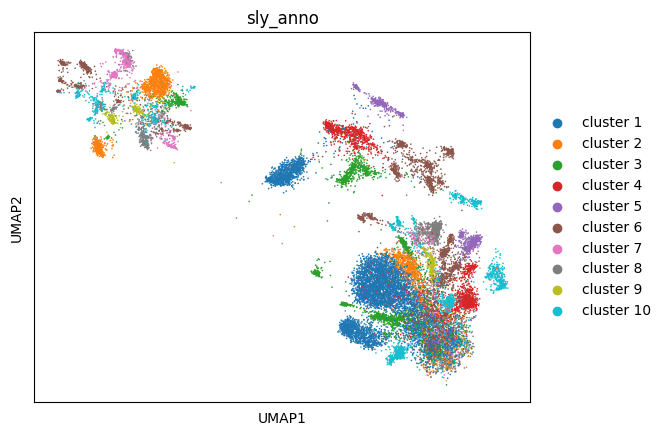

In [117]:
import anndata as ad 

tmp = []
for species in node2id:
    tmp.append(data_dic[species])
new_data = ad.concat(tmp)
new_data.obsp['connectivities'] = sparse_mat_csr

tmp = {'connectivities_key': 'connectivities',
 'distances_key': 'distances',
 'params': {'method': 'umap',
  'metric': 'sr_modify',
  'n_neighbors': 15,
  'random_state': 0,
  'use_rep': 'X_pca_harmony'}}
  
new_data.uns['neighbors'] = tmp
sc.tl.umap(new_data,min_dist = 0.1)
sc.pl.umap(new_data,color = 'sly_anno')

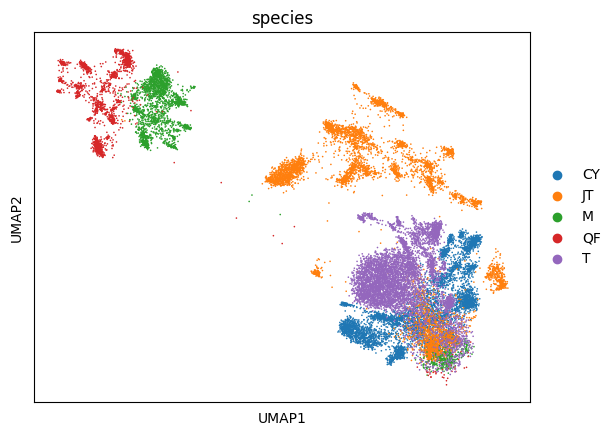

In [118]:
sc.pl.umap(new_data,color = 'species')

## NOT USED

In [142]:
# 获取 dist 矩阵
raw_dist = scdata.obsp['connectivities'].toarray()

In [ ]:
t_idx = np.logical_and(scdata.obs.species == 'T', scdata.obs.new_anno == 'DG Glut-(non eco)')  # 分错的猪尾鼠id
n_idx = np.logical_and(scdata.obs.species.isin(['M','QF']), scdata.obs.new_anno == 'DG Glut-(non eco)') # 全部非回声猪尾鼠id
e_idx = np.logical_and(scdata.obs.species.isin(['T']), scdata.obs.new_anno == 'DG Glut-(eco)') #正确的猪尾鼠id 
all_e_idx = scdata.obs.new_anno == 'DG Glut-(eco)'  ## 全部回声物种id

print(t_idx.sum(), e_idx.sum(), n_idx.sum(), all_e_idx.sum())
idx = np.arange(scdata.shape[0])
t_idx = idx[t_idx]
n_idx = idx[n_idx]
e_idx = idx[e_idx] 
all_e_idx = idx[all_e_idx]

# 获取 dist 矩阵
dist = raw_dist.copy()

# 选取 92 % 的错分的猪尾鼠id 与 正确的猪尾鼠 id 建立连边, 

sel_id = np.random.choice(t_idx, int(0.9*len(t_idx)), replace=False)
dist[sel_id, :] = 0
dist[:,sel_id] = 0

res = []
for i in range(len(sel_id)):
    x = sel_id[i]
    N_x = np.random.choice(e_idx, 10, replace=False)
    tmp = 0.2*np.random.rand(10)
    dist[x, N_x] = tmp 
    dist[N_x, x] = tmp
    
# 非回声的物种和回声物种之间连边置0

#dist[n_idx,:][:,all_e_idx] = 0

#dist[all_e_idx,:][:,n_idx] = 0
from scipy.sparse import csr_matrix
csr_dist = csr_matrix(dist)

660 3274 1298 6006


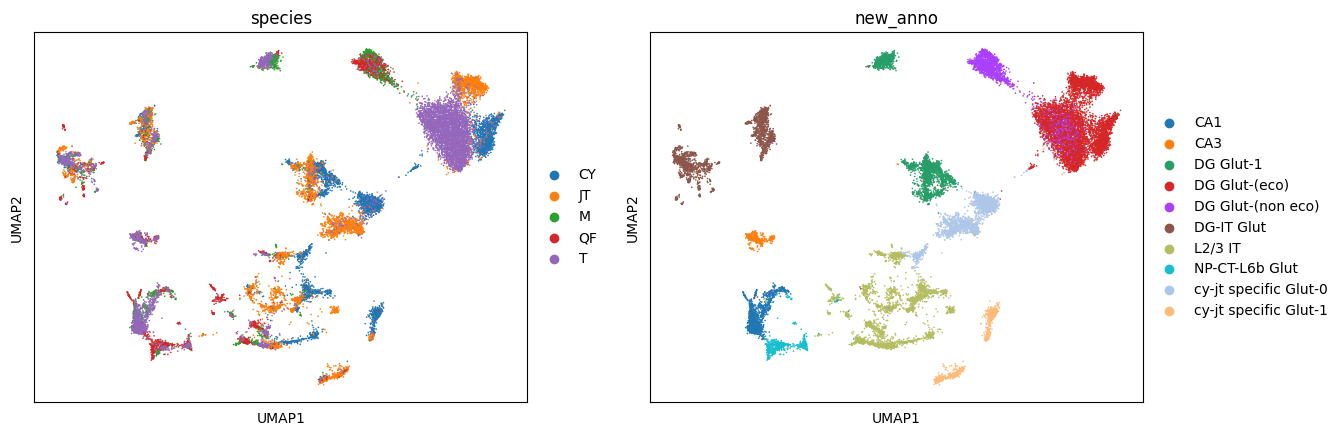

In [159]:
scdata.obsp['connectivities'] = csr_dist 
sc.tl.umap(scdata,min_dist=0.1)
sc.pl.umap(scdata, color = ['species','new_anno'])

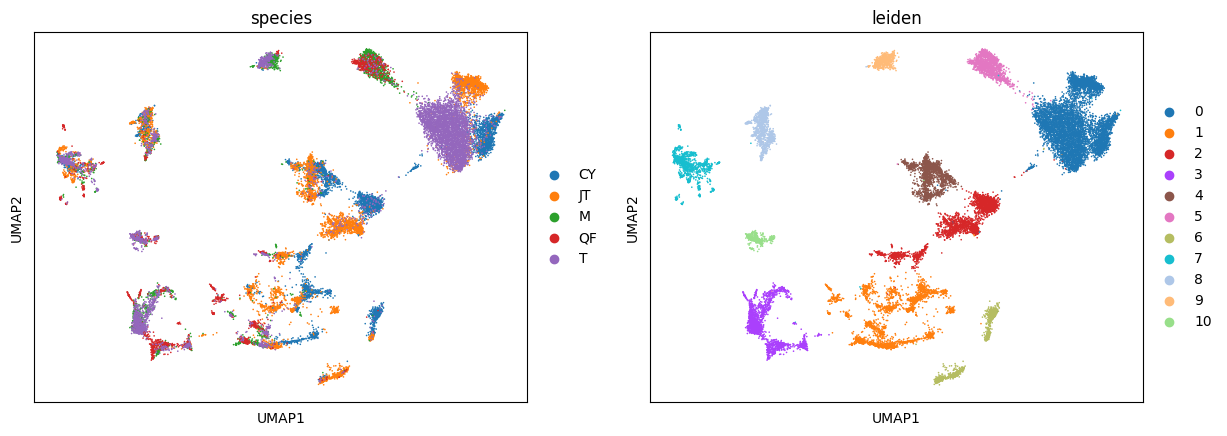

In [160]:
sc.tl.leiden(scdata, resolution = 0.3)
sc.pl.umap(scdata, color = ['species','leiden'])

In [164]:
scdata.write('modify_multi.h5ad')

In [161]:
pd.crosstab(scdata.obs.species, scdata.obs.leiden)

leiden,0,1,2,3,4,5,6,7,8,9,10
species,,,,,,,,,,,
CY,1375,871,1161,3,784,0,631,208,281,49,0
JT,1368,1002,1188,25,863,8,569,272,452,37,5
M,6,211,41,570,26,877,4,154,133,285,138
QF,2,551,35,572,11,407,15,236,43,21,140
T,3880,203,151,796,62,58,25,361,171,260,264


6019


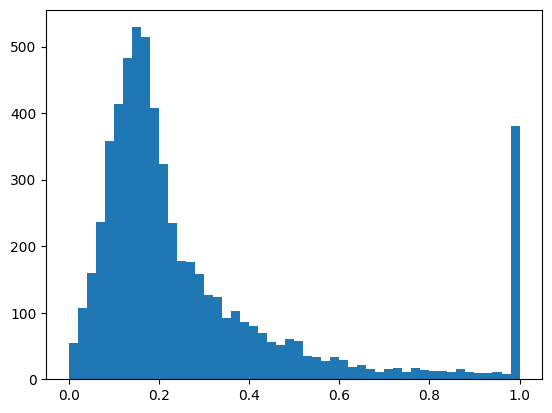

In [49]:
tmp = dist[t_idx,:][:,e_idx].flatten()
print((tmp > 0).sum())
tmp = tmp[tmp > 0]
plt.hist(tmp, bins = 50)
plt.show()

In [44]:
tmp.max()

1.0

(477903321,)
(472430,)


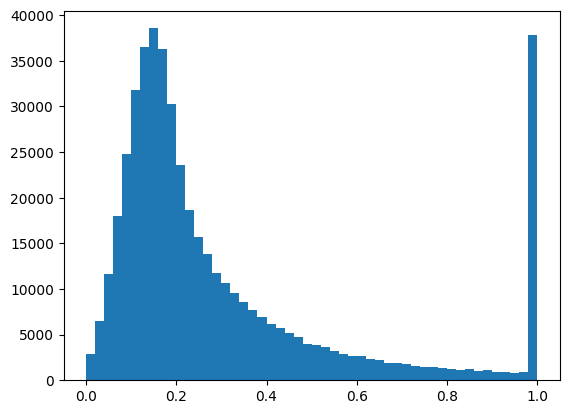

In [32]:
dist = scdata.obsp['connectivities'].toarray()

import matplotlib.pyplot as plt 

tmp = dist.flatten()
print(tmp.shape)
tmp = tmp[tmp>0]
print(tmp.shape)

plt.hist(tmp, bins = 50)
plt.show()

In [ ]:
t_idx = scdata.